<a href="https://colab.research.google.com/github/JoaoConrado/IA/blob/main/Controle_MotorCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Programe, treine e teste sua Rede Neural artificial #

## **Intereção**

O código abaixo irá executar as previsões baseada no seu modelo (o nome deve ser motorccRNA). A saída terá 2 gráficos, o primeiro com o Torque aleatório usado e o segundo com a Velocidade Controlada pelo seu modelo.

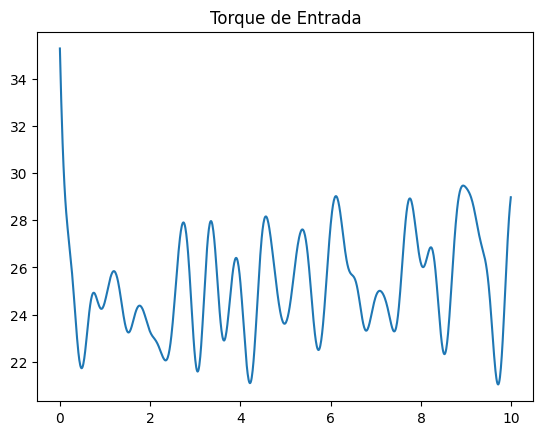

Erro: Dados de entrada faltando ou inválidos!
Erro: Execute todo o código e caso persista, envie essa print para o professor!


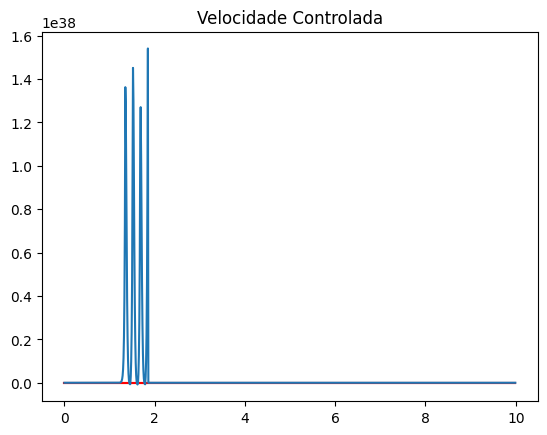

In [ ]:
from scipy import signal
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import random

fabiano = tf.keras.models.load_model('/content/sample_data/motorcc64x128x64RNAV3.keras')

# Constantes do motor

pi = math.pi

Pn = 7457 # Potência nominal (W)
Vn = 240  # Tensão nominal de armadura (V)
Vfn = 300 # Tensão nominal de campo (V)
wn = 1750 * 2 * pi / 60 # velocidade angular nominal (rad/s)
Tn = Pn / wn # Torque nominal (Nm)

Ra = 1.086    # Resistência do armadura (Ohms)
La = 0.01216  # Indutância do armadura (H)
Rf = 180
Lf = 71.47
Laf = 0.6458 # Este é o Kv da simulação matlab
J = 0.04251   # Inércia do rotor (kg.m^2)
B = 0.003406    # Coeficiente de atrito viscoso (Nms)
Tf = 1.046

If = Vfn / Rf
Ke = Laf*If
Kt = Ke


# Parâmetros de simulação
dt = 1e-2  # Passo de tempo (s)
t_sim = 10

# Inicialização
t = np.arange(0, t_sim, dt)
i = np.zeros_like(t)
w = np.zeros_like(t)
V_debug = np.zeros_like(t)
V_debug[0] = 0
V = 0

max = np.ones_like(t) * 200
min = np.ones_like(t) * 180

# Condições iniciais
i[0] = 0
w[0] = 100

# Gerar ruído aleatório
ruido = np.random.rand(len(t))

# Criar um filtro passa-baixa Butterworth
fc = 2  # Frequência de corte (ajuste para controlar a suavidade)
ordem = 4  # Ordem do filtro (ajuste para controlar a suavidade)
b, a = signal.butter(ordem, fc * dt * 2, 'lowpass')

T_minimo = 0.1 * Tn  # Valor mínimo de torque
T_suave = signal.filtfilt(b, a, ruido) * Tn + T_minimo

# # Plotar o ruído original e o ruído suavizado
plt.title('Torque de Entrada')
plt.plot(t, T_suave)
plt.show()

# Loop de simulação
for k in range(len(t) - 1):
    T = T_suave[k]

############ Safeguards ############

    nova_entrada_teste = np.array([T, w[k], i[k]])
    if np.isnan(nova_entrada_teste).any() or np.isinf(nova_entrada_teste).any():
      print("Erro: Dados de entrada faltando ou inválidos!")
      print("Erro: Execute todo o código e caso persista, envie essa print para o professor!")
      break
      # Handle the error, e.g., impute missing values or skip the prediction

    nova_entrada_teste2 = np.array([T, w[k], i[k]], dtype=np.float32) # Specify data type
    if nova_entrada_teste2.dtype not in (np.float32, np.float64):
      print("Error: Entrada com tipo errado.")
      print("Erro: Execute todo o código e caso persista, envie essa print para o professor!")
      break
      # Handle the error, e.g., convert data type

############ Fim das safeguards ############

# Predição usando o modelo
    try:
      nova_entrada = np.array([T, w[k], i[k]])
      nova_entrada = nova_entrada.reshape(1, -1)
      nova_saida = fabiano.predict(nova_entrada, verbose=0)
    except ValueError:
      print("Erro: Formato da entrada incorreto.")
      print("Erro: Execute todo o código e caso persista, envie essa print para o professor!")


      # Handle the error, e.g., adjust the reshape operation

# DEBUG
    V_debug[k] = nova_saida[0][0]

#################

    V = nova_saida[0][0]

    # Calcular a corrente e a velocidade no próximo passo de tempo
    i[k+1] = i[k] + dt * (V - Ra*i[k] - Ke*w[k]) / La
    w[k+1] = w[k] + dt * (Kt*i[k] - T - B*w[k]) / J

# # Plotar os resultados
plt.title('Velocidade Controlada')
plt.plot(t, max, color = 'red', )
plt.plot(t, min, color = 'red')
plt.plot(t, w)
plt.show()